In [5]:
import requests, zipfile, io

url = "https://github.com/Sakthivel-coder12/Banana_diseases/raw/main/banana_dataset.zip"

# download + unzip in one go
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("banana")

# check extracted folders
import os
print(os.listdir("banana"))


['banana']


In [11]:
print(os.listdir("banana/banana"))

['disease', 'healthy']


In [15]:
img_size = (224,224)
batch_size = 32
seed = 42
dataset_dir = "banana/banana"

In [ ]:
# import zipfile

# with zipfile.ZipFile("your_folder.zip", "r") as zip_ref:
#     zip_ref.extractall("your_folder")


In [26]:
import tensorflow as tf
import os

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split = 0.30,
    subset = "training",
    seed = seed,
    image_size  = img_size,
    batch_size = batch_size
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split = 0.30,
    subset = "validation",
    seed = seed,
    image_size = img_size,
    batch_size = batch_size
)


Found 259 files belonging to 2 classes.
Using 182 files for training.
Found 259 files belonging to 2 classes.
Using 77 files for validation.


In [32]:
len(temp_ds)

3

## split the temp_ds into testing and validation_data set

In [33]:
size = int(len(temp_ds) * 0.5)
test_ds = temp_ds.take(size)
val_ds = temp_ds.skip(size)


print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

6
1
2


## let's create the CNN Model

In [51]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt



## The model defination
model = models.Sequential([
    layers.Rescaling(1./255,input_shape = img_size + (3,)),
    layers.Conv2D(filters = 32,kernel_size = (3,3),activation = "relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,3,activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128,3,activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128,activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(1,activation = "sigmoid")
])

In [59]:
model.compile(loss = "binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(), # "adam"
              metrics = ["accuracy",
                        tf.keras.metrics.Precision(name = "precision"),
                        tf.keras.metrics.Recall(name= "recall"),
                        tf.keras.metrics.AUC(name = "AUC")])


history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 4,
    steps_per_epoch = len(train_ds),
    validation_steps = len(val_ds)
)

Epoch 1/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 836ms/step - AUC: 0.6021 - accuracy: 0.6063 - loss: 1.0583 - precision: 0.6064 - recall: 0.5725 - val_AUC: 0.6986 - val_accuracy: 0.4889 - val_loss: 0.6869 - val_precision: 0.4889 - val_recall: 1.0000
Epoch 2/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 608ms/step - AUC: 0.6817 - accuracy: 0.6620 - loss: 0.6486 - precision: 0.6505 - recall: 0.7863 - val_AUC: 0.8330 - val_accuracy: 0.7778 - val_loss: 0.5736 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 3/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 595ms/step - AUC: 0.7896 - accuracy: 0.7425 - loss: 0.5974 - precision: 0.7384 - recall: 0.7366 - val_AUC: 0.9634 - val_accuracy: 0.7778 - val_loss: 0.4341 - val_precision: 1.0000 - val_recall: 0.5455
Epoch 4/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 610ms/step - AUC: 0.9076 - accuracy: 0.8447 - loss: 0.4199 - precision: 0.9074 - recall: 0.7381 - val_AUC: 0.9842 - val_accuracy: 0.9111 - val_loss: 0.2268 - val_precision: 0.8519 - val_recall: 1.0000


In [64]:
test_loss, test_acc, test_prec, test_rec, test_auc =model.evaluate(test_ds)
print("\n=== Test Results ===")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall : {test_rec:.4f}")
print(f"AUC : {test_auc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - AUC: 0.9804 - accuracy: 0.8750 - loss: 0.2378 - precision: 0.8421 - recall: 0.9412

=== Test Results ===
Accuracy : 0.8750
Precision: 0.8421
Recall : 0.9412
AUC : 0.9804


Text(0, 0.5, 'Loss')

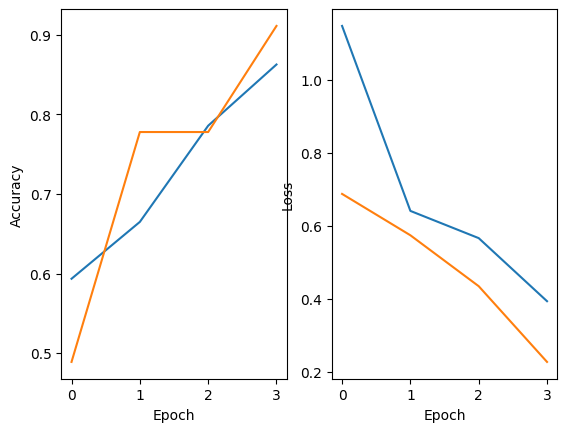

In [75]:
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"],label = "train_ds")
plt.plot(history.history["val_accuracy"],label = "val_ds")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"],label = "loss")
plt.plot(history.history["val_loss"],label = "val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
[0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1]


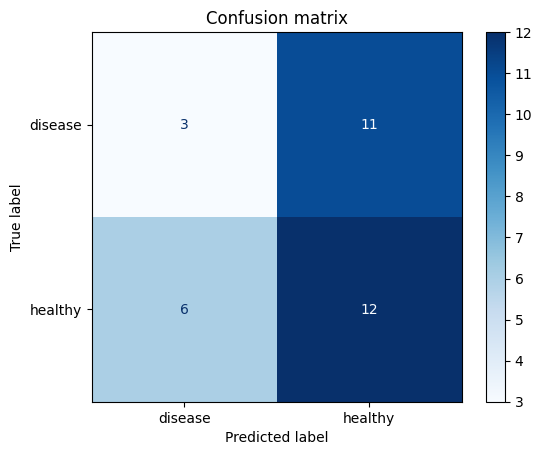

In [107]:
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
y_true = np.concatenate([y for x,y in test_ds],axis = 0)
y_pred_pro = model.predict(test_ds)
y_pred = (y_pred_pro>0.5).astype("int32").flatten()
print(y_pred)
cm = confusion_matrix(y_true,y_pred)
con = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = train_ds.class_names)
con.plot(cmap = "Blues")
plt.title("Confusion matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


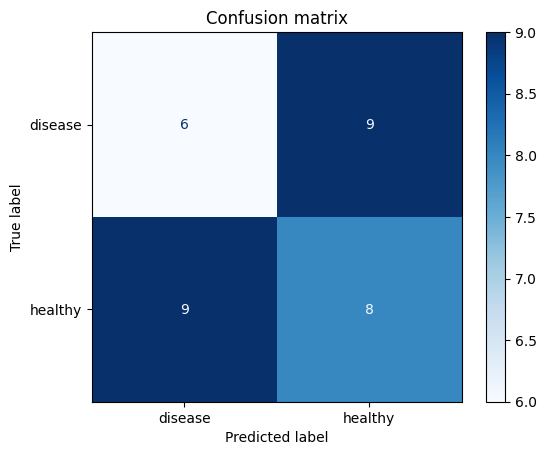

In [105]:
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


y_true = np.concatenate([y for x,y in test_ds],axis = 0)
y_pred_pro = model.predict(test_ds)
y_pred = (y_pred_pro>0.5).astype("int32").flatten()

cm = confusion_matrix(y_true,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = train_ds.class_names)
disp.plot(cmap = "Blues")
plt.title("Confusion matrix")
plt.show()



